## Principal Component Analysis (PCA)

> PCA is a dimensionality reduction technique useful for gaining insight into the behavior of a data set. The resulting lower dimensional feature space can be used for further downstream ML tasks such as classification.

There are multiple derivations of the results. The problem can be framed in equivalent ways, such as obtaining the eigenvector/eigenvalue pairs of the data's covariance matric, the calulation of the Singular Value Decomposition (SVD), and solving an optimization problem. In this notebook, we briefly summarize the calulation of the Principal Components in a non-rigorous way, generate a contrived example from a system of differential equations, and see what inferences can be made from PCA in a purely data driven approach to analyszing that system.

Before doing this, there are two important considerations prior to implementing PCA: _feature preprocessing_ and *assumptions of the algorithm*.

<u>__Requirements__<u>

- Data should be shifted to a mean of zero (subtract the mean of each feature).
- Data should be recorded on the same scale. If they are different units or scales, then one may dominante te algorithm and return bad results. In this case the approach it often to standardize the data (subtract the mean and divide by the standard deviation)
- There must be a linear correlation between the features.*

*Imagine a case of independent Gaussian variables in $R^3$. Then after centering and standardizing, PCA would be acting on a ball centered at the origin, and hence not return significant results. Valuable reults might still be obtained in this case if not standardizing. This is however a rare case.

<u>__Algorithm__<u>

Assume observed data is organized in a matrix $X \in R^{n \times m}$, with $n$ samples of $m$ features each.

PCA aims to find _p_ orthogonal directions on which to project the data, with $p<m$. These directions will capture the maximum variability in the data. In order to accomplish this, we caluclate the covariance matrix of $X$:
$$C \equiv Cov(X) = X^TX \in R^{m \times m}$$
This is a symmetric matrix with off diagonals non-zero. We can diagonalize $C$ by finding its corresponding eigevectors and eigenvalues:
$$C = V \Lambda V^{-1}$$

The entries in the diagonal matrix $\Lambda$ give the variances in each principal direction and the column vectors in $V$ give the principal directions we wish to project the data onto. This projection of our data is called the _principal components_ and is calulated as $Y = XV$. The data in this new space can be shown to have a diagonal covariance matrix (by calulating $Y^{T}Y$). This means the data features are now independent in this eigenbasis.

<u>__Application__<u>

Consider the linear system of differential equations given by $A \in R^{2 \times 2}$: $$\dot{\vec{y}} = A \vec{y}$$

The solution $\vec{y}(t) = [x_1(t), x_2(t)]^T$ for some initial condition at $t = 0$ has the form: $$\vec{y} = e^{At}\vec{y(0)}$$
The matrix exponential evaluates to a matrix and can be calculated using the power series definition of $e^x$.

The value of the matrix $A$ determines what type of system we have. We choose $A$ carefully so that it has purely imaginary (of the form $\pm bi$ for some b) eigenvalues. This guarantees the solution isa _center_ (elliptical solutions about the origin) and will not spiral to infinity or zero. Such a requirement is satisfied by setting: $$A = \begin{bmatrix}0&1\cr-9&0\end{bmatrix}$$

In this case, the eigenvalues are $\pm 3i$. The corresponding eigenvectors are also complex because the eigenvalue is complex. They also come in conjugate pairs: $$\vec{v} = \begin{pmatrix} \pm i /3 \cr1\cr\end{pmatrix}$$

Given the complex eigenvalues, we know this system has two linearly independent solutions that are real-valued. They will take the form
$\vec{s_1} = \operatorname{Re}(s^*)$ and $\vec{s_2} = \operatorname{Im}(s^*) $, where $$s^* = \begin{pmatrix} -i /3 \cr1\cr\end{pmatrix} e^{3it} $$ 

The general solution is therefore given by: $$\vec{y}(t) = c_1\vec{s_1} + c_2\vec{s_2}$$

This gives us the general solution:

$$\vec{y(t)} = c_1 \begin{pmatrix} sin(3t)/3 \cr cos(3t) \cr\end{pmatrix} + c_2 \begin{pmatrix} -cos(3t)/3 \cr sin(3t) \cr\end{pmatrix}  $$

If we start at the coordinate $\begin{pmatrix} 3 \cr3\cr\end{pmatrix} $, then out specific solution is parameterized by: $$ \vec{y(t)} = \begin{pmatrix} sin(3t) + 3cos(3t) \cr 3cos(3t) -9sin(3t) \cr\end{pmatrix} $$

This corresponds to an ellipse oscillating around the origin in the $x$ and $y$ directions. The following image shows the vector field of this system and the unique solution to our initial condition (gray square is the starting point, moving clockwise). The image is generated by the phase plane plotter [located here](https://aeb019.hosted.uark.edu/pplane.html) by Ariel Barton.

<center><img src="oscillation_pca.png"/></center><br>

Note if $y = 0$, there is no motion is the x direction. Further, if $x = 0$, there is no motion in the y direction. This is consistent with the $A$ matrix above.

At this point, it is worth pointing out that the derivatives of each feature are related in a linear way by $A$, however the variables themselves are not linearly related. They are ellipses in $x$ and $y$ (quadratics). Generally, PCA is not the approach for this type of problem. Generally a system like this is unstable and swirls around the origin, making PCA useless. In this special case, however, the system is stable and is centered at the origin, so PCA might return _something_ valuable.

Another observation is that minus the inside of the ellipse being empty, this might be reminiscent of two independent Gaussian variables in $x$ and $y$. Recall that for independent Gaussian variables, PCA has no use since the covariance matrix will show $0$ correlation between variables and hence already be diagonal. In this case, you can simply project onto the axis (axes) with the highest variance as they will already be orthogonal. If you were to apply PCA, you would need to do so without standardizing due to the reason (*) mentioned above. PCA would then pick out these axes for you, which should be the unit axes with eigenvalues equal to the respective variances. If you had Gaussians that were linearly related (imagine a rotated $3D$ ellipse/cloud made from Gaussians, for example), then PCA will do the same thing, but apply a rotation to the data first. Standardizing in this case is acceptable. These cases are unlikely as we assume some relationship between variables when applying PCA, but instructive nevertheless.

The actual distribution for $x$ and $y$ will depend on the time dynamics of the problem. For example, it might turn the top and bottom corners more slowly than transversing the curve in the vertical direction. The quantity we see will depend on the interval of time we sample from and the sampling frequency (see below histograms). 

<u>__Truth Plots__<u>

First, we take the solutions in time and plot them to better understand the system dynamics. Since one period of oscillation is $\frac{2\pi}{3}$ units of time, we plot from $t = 0$ to $t = p\frac{2\pi}{3} $ to visualize $p$ periods, coded below to be configurable. Note plotly allows you to hover over charts to view the values and labels.

In [16]:
# imports
import numpy as np
import plotly.express as px

In [17]:
p = 5 # p >= 1
L = p*(2*np.pi/3 + 0.01)
t = np.arange(0, L , 0.1)
x_t = np.sin(3*t) + 3*np.cos(3*t)
y_t = 3*np.cos(3*t) - 9*np.sin(3*t)

fig = px.line({'t': t, 'x(t)': x_t, 'y(t)':y_t}, x='t', y = ['x(t)', 'y(t)'], title = f'Solutions in time with {p} periods shown')
for i in range(1, p + 1):
    fig.add_vline(x = i*2*np.pi/3)
fig.show()

Now we visualize the distribution of $x$ and $y$ for a simulated trip around the ellipse by setting a specific sampling frequency $\Delta t$ and $p$ periods of revolution. We can see the solution will have a distribution heavily weighted towards the ends for both $y$ and $x$ as 'corners' are turned.

In [18]:
dt = 0.01
p = 3
nbins = 100
L = p*(2*np.pi/3)
t = np.arange(0, L , dt)
x_t = np.sin(3*t) + 3*np.cos(3*t)
y_t = 3*np.cos(3*t) - 9*np.sin(3*t)
fig = px.histogram({'t': t, 'x(t)': x_t, 'y(t)':y_t},
                   x= ['x(t)', 'y(t)'],
                   title = f'Histogram of x and y using dt = {dt} with {nbins} bins over {p} periods.',
                   marginal="rug",
                   opacity=0.5,
                   barmode = 'overlay',
                   nbins = nbins)
fig.show()

<u>__Data Driven Analysis__<u>

Our goal now is to start with this solution and simulate observed data points from this system using multiple viewpoints in $3D$ space. This will provide a high dimensional observation set of what should be a $2D$ system. We introduce random noise to simulate error in the sensors or the system. Then, we will run a principal componet analysis and see what information it reveals.

First, add noise to the system and visualize.

In [19]:
L = 10*(2*np.pi/3) #do 10 rotations of the ellipse
t = np.arange(0, L , 0.1)
x_t = np.sin(3*t) + 3*np.cos(3*t) + np.random.normal(loc=0.0, scale=0.6, size=len(t))
y_t = 3*np.cos(3*t) - 9*np.sin(3*t) + np.random.normal(loc=0.0, scale=0.6, size=len(t))
fig = px.scatter({'t': t, 'x(t)': x_t, 'y(t)':y_t},
                 x='x(t)',
                 y = 'y(t)',
                 title = f'x versus y scatter plot with normal noise',
                 width = 500,
                 height = 700,
                 range_x = [-6, 6],
                 range_y = [-12, 12])
fig.show() 

We now define four planes using their orthogonal basis vectors and project the data onto them.

In [20]:
initial_points = np.vstack([x_t, np.zeros(len(x_t)), y_t])

#2 vertical, 2 horizontal viewpoint modifications
planes_rotation = [[[1, 5, 0],[0, 0, 1]], 
                      [[10, -1, 0],[0, 0, 1]],
                      [[0, 5, 1],[1, 0, 0]], 
                      [[0, 2, 1],[1, 0, 0]]]

proj_arrs_categ = {}
for ix, plane in enumerate(planes_rotation):
    #make unit vectors, this helps make sure the projections are each referring to the same 'unit' length
    plane_arr = np.array(plane).T
    normed_basis = plane_arr/np.linalg.norm(plane_arr, axis = 0)
    #print(normed_basis.T @ normed_basis) #should be the identity
    #project the data, only need the transpose
    proj = normed_basis.T @ initial_points
    proj_arrs_categ[ix] = proj

Now, we plot the new data to inspect it. Note the above vectors correspond to rotating your viewpoint about the vertical axis if viewing the orginal data in 3 dimensions with 0 y-coordinates on the xyz-coordinate system.

In [21]:
plane_data_to_plot = 0 #0, 1, 2, or 3

pts = proj_arrs_categ[plane_data_to_plot] #shape (2, N)

fig = px.scatter(x=pts[0,:],
                 y = pts[1,:],
                 title = f'Data projected onto plane {plane_data_to_plot + 1}',
                 width = 500,
                 height = 700,
                 range_x = [-12, 12],
                 range_y = [-12, 12])
fig.show() 

Form the full projected dataset acting as the observd data. It has shape (N samples, 8).

In [22]:
arr_ls = [i.T for i in proj_arrs_categ.values()]
X = np.hstack(arr_ls)
print(X.shape) 

(210, 8)


Perform the steps of PCA.

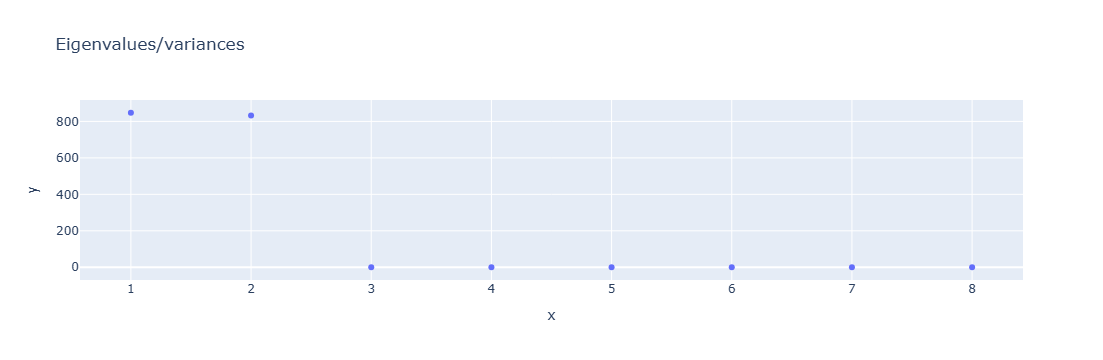

Eigenvalues =  [847.5597746370262, 832.4402253629737, 2.990382879698226e-14, 1.4458408062374776e-14, 5.461178111400373e-15]
Explained variance =  100.0 %


In [28]:
X_st = (X - np.mean(X, axis = 0))/np.std(X, axis = 0)

C = X_st.T @ X_st
eigenvalues, eigenvectors = np.linalg.eig(C)
sorted_evals, sorted_evecs = zip(*sorted(zip(eigenvalues, eigenvectors), reverse = True))
sorted_evals = [i.real for i in sorted_evals]

#plot the eigenvalues
fig = px.scatter(x=range(1, len(sorted_evals) + 1),
                 y = sorted_evals,
                 title = f'Eigenvalues/variances')
fig.show() 

#find the principal components using the first two eigenvectors
V = np.hstack([sorted_evecs[0].reshape(-1, 1), sorted_evecs[1].reshape(-1, 1)])
PC = X_st @ V #shape (N, 2)
explained_variance = sum(sorted_evals[:2])/sum(sorted_evals)
print('Eigenvalues = ', sorted_evals[:5])
print('Explained variance = ', 100*explained_variance, '%')

It is clear the vast majority of the variance in this system is captured by the <u>first two principal components</u>, so we projected onto the first two eigenvectors. We started with 8-dimensional data and were able to reduce it down to 2 dimensions while preserving nearly $100\%$ of the variance. Obviously in this very synthetic example, this is perfect, but in reality expect much lower.

Now, let's see what $x$ and $y$ look like when graphed together as a scatter plot.

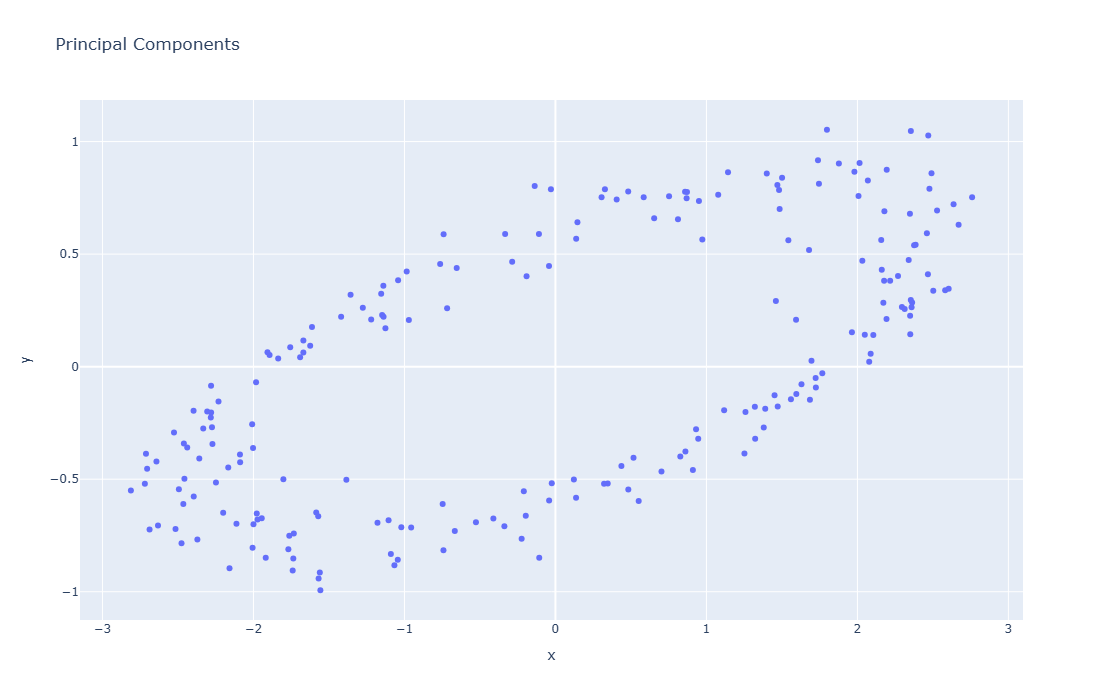

In [29]:
fig = px.scatter(x=PC[:,0],
                 y = PC[:,1],
                 title = f'Principal Components',
                 width = 500,
                 height = 700)
fig.show() 

We have what roughly looks like our original ellipse, but rotated. When we generated our synthetic viewpoints of the data, we lost information regarding spatial relationships. This is however not the issue. Recall that the points are not evenly distributed spatially (you can see some clustering at the ends in this plot), which causes this rotation. However, we can still detect the fact that the boundaries of the range of $y$ are approximately $3$ times that of $x$. In fact, the slope of the line from the origin through the top right corner appears to be approximately $3$. That is, $y \approx 3x$ 'most of the time'. We can see from the truth $x(t)$ and $y(t)$ plots from the beginning of the notebook that when $x = \pm3$, $y$ is increasing quickly to $\pm 9$ and stays there until the slower $x$ dynamics push it over the corner to the next corner.

Speaking of time, we can view the time dynamics that the principal components estimated.


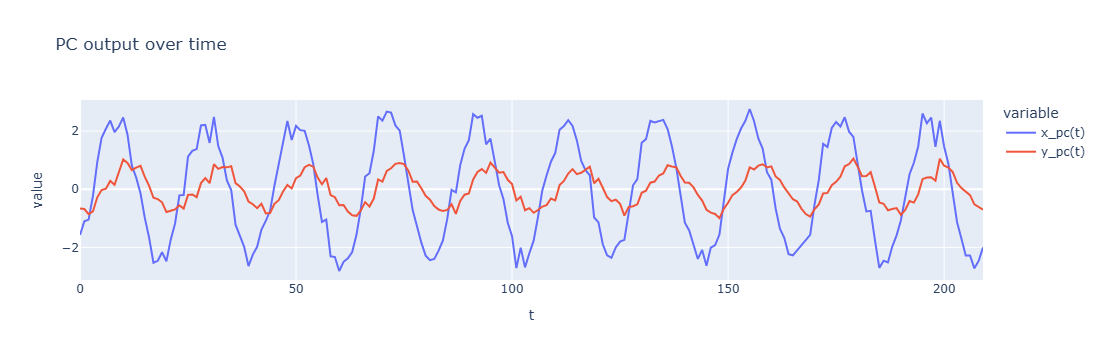

In [30]:
t = np.arange(len(PC))

fig = px.line({'t': t, 'x_pc(t)':PC[:,0], 'y_pc(t)': PC[:,1]}, x = 't', y = ['x_pc(t)', 'y_pc(t)'], title = f'PC output over time')
fig.show()

This is a pretty close approximation to the above $x(t)$ and $y(t)$ plots.

In conclusion, PCA can provide a way to reduce the dimensionality of data while preserving key relationships and revealing interesting facts.